In [1]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
fetch_housing_data()

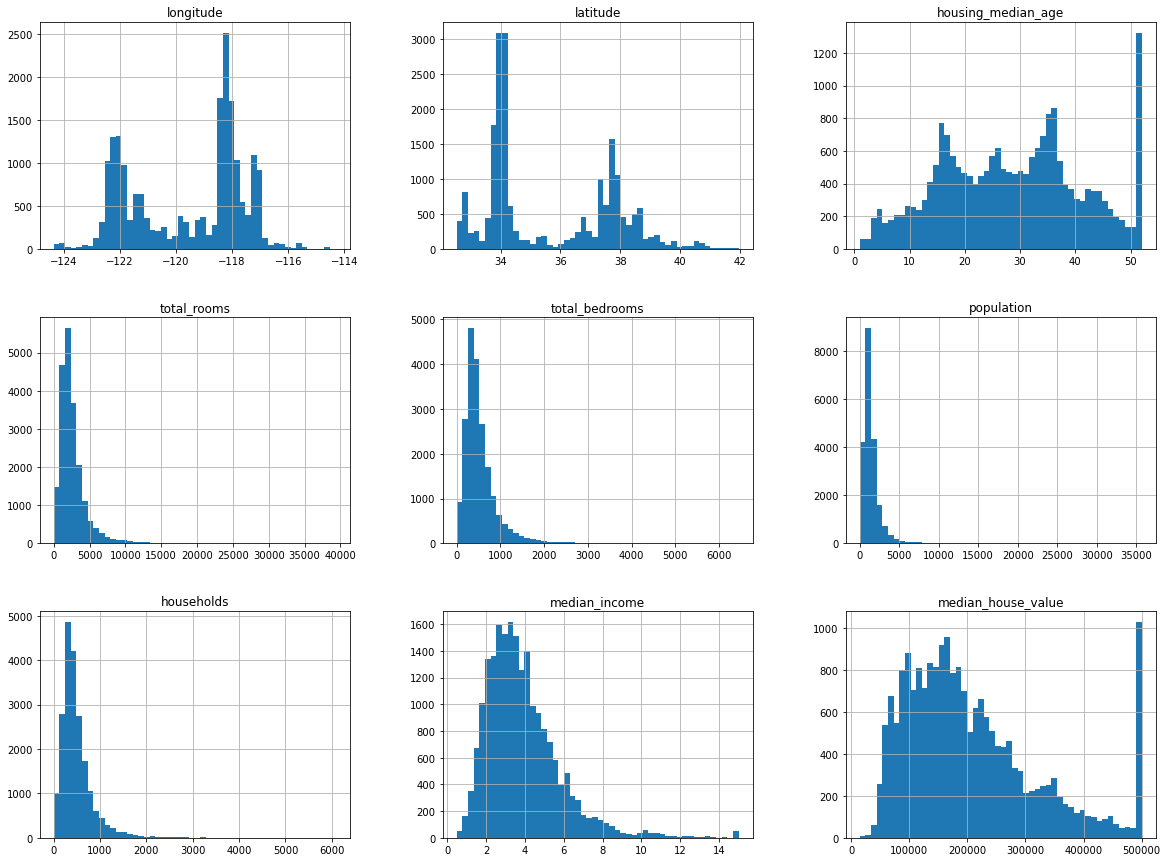

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

housing = load_housing_data()
housing.hist(bins=50, figsize=(20,15))
plt.show()

In [3]:
import numpy as np

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = split_train_test(housing, 0.2)
train_set


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
9953,-122.36,38.41,18.0,1808.0,400.0,968.0,370.0,3.7067,175000.0,INLAND
2038,-119.69,36.74,17.0,2438.0,598.0,1563.0,538.0,1.5449,62500.0,INLAND
10731,-117.87,33.59,44.0,2499.0,396.0,910.0,374.0,6.6544,500001.0,<1H OCEAN
2693,-115.39,32.76,16.0,1136.0,196.0,481.0,185.0,6.2558,146300.0,INLAND
3375,-118.28,34.25,35.0,2045.0,450.0,1166.0,407.0,3.5214,197600.0,<1H OCEAN
...,...,...,...,...,...,...,...,...,...,...
5389,-118.40,34.03,13.0,6152.0,1978.0,3397.0,1845.0,3.4058,275000.0,<1H OCEAN
18354,-122.11,37.36,34.0,1575.0,183.0,511.0,180.0,13.1867,500001.0,NEAR BAY
13887,-115.53,34.91,12.0,807.0,199.0,246.0,102.0,2.5391,40000.0,INLAND
9172,-118.59,34.47,5.0,538.0,98.0,8733.0,105.0,4.2391,154600.0,INLAND


In [4]:


# Use identifier in order to not generate a new dataset everytime it gets updated or run

from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

housing_with_id = housing.reset_index()
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")


In [5]:
0xffffffff

4294967295

<AxesSubplot:>

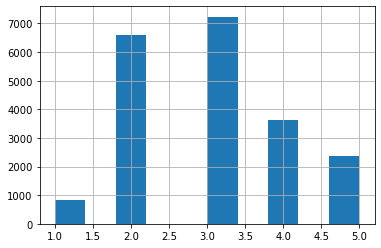

In [6]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

housing["income_cat"].hist()


In [7]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)

for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
    
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [8]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [9]:
housing = strat_train_set.copy()
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16354 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   median_house_value  16512 non-null  float64
 9   ocean_proximity     16512 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.4+ MB


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

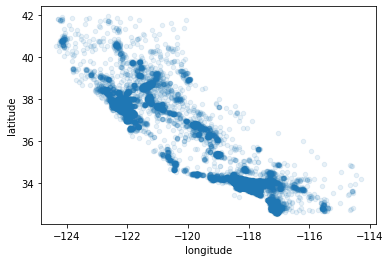

In [10]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

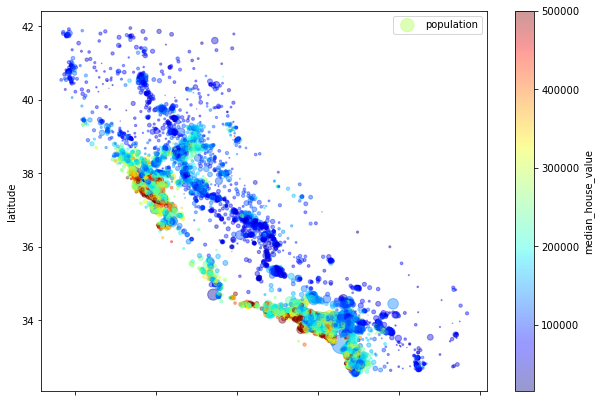

In [11]:
housing.plot(kind = "scatter", x = "longitude", y = "latitude", alpha = 0.4,
            s = housing["population"] / 100, label = "population", figsize = (10, 7),
            c = "median_house_value", cmap = plt.get_cmap("jet"), colorbar = True)

plt.legend()

In [12]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=True)

latitude             -0.142724
longitude            -0.047432
population           -0.026920
total_bedrooms        0.047689
households            0.064506
housing_median_age    0.114110
total_rooms           0.135097
median_income         0.687160
median_house_value    1.000000
Name: median_house_value, dtype: float64

array([[<AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='total_rooms'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='housing_median_age'>,
        <AxesSubplot:xlabel='median_incom

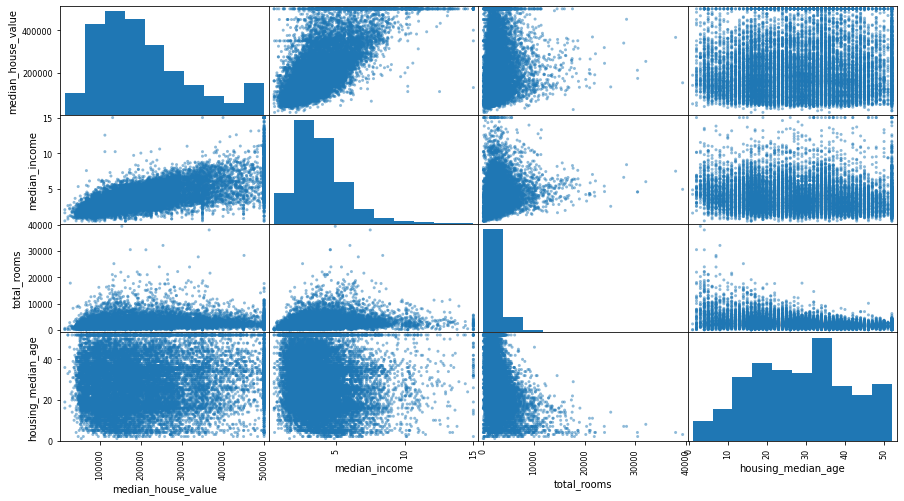

In [13]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize = (15, 8))

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

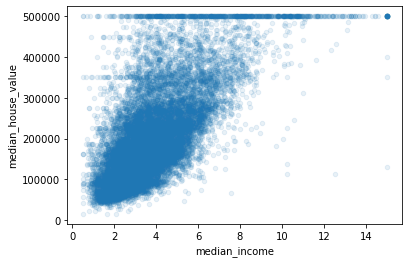

In [14]:
housing.plot(kind = "scatter", x = "median_income", y = "median_house_value", alpha = 0.1)

In [15]:
housing["room_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)


median_house_value          1.000000
median_income               0.687160
room_per_household          0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

In [16]:
# Preparing the data for ML algorithms

housing = strat_train_set.drop("median_house_value", axis = 1)
housing_labels = strat_train_set["median_house_value"].copy()

# Data cleaning
# When missing values: 1. get rid of the values 2. get rid of the attribute 3. set values to some value (zero ,mean etc.)

from sklearn.impute import SimpleImputer
print(housing["ocean_proximity"].shape)
imputer = SimpleImputer(strategy = "median")
housing_num = housing.drop("ocean_proximity", axis = 1)
imputer.fit(housing_num)
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns = housing_num.columns, index = housing_num.index)
housing.info(), housing_tr.info()


(16512,)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16354 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   ocean_proximity     16512 non-null  object 
dtypes: float64(8), object(1)
memory usage: 1.3+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            1651

(None, None)

In [17]:
# Handling text and categorical attributes

housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)
housing_cat.info()
housing_cat.shape, housing["ocean_proximity"].shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ocean_proximity  16512 non-null  object
dtypes: object(1)
memory usage: 258.0+ KB


((16512, 1), (16512,))

In [18]:
# converting category from text to numbers
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [19]:
# One-hot encoding - one attribute equal to 1, others to 0 - some ML algorithms may decide that valeus nearby in 1D array might be more similar than a distanced ones
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
cat_encoder.categories_, housing_cat_1hot

([array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
        dtype=object)],
 <16512x5 sparse matrix of type '<class 'numpy.float64'>'
 	with 16512 stored elements in Compressed Sparse Row format>)

In [20]:
# Feature scalling - min-max scalling (normalization)
# Formula for normalization:  (X - XMin) / (XMax -  XMin)
# We end up with featrues ranging from 0 to 1
# Also can be done by Scikit-Learn MinMaxScaler
# Why? 1. ML algo perform well when the input numerical attr have similar scale.

# Standarization
# Formula for standarization: (X - Xmean) / Xstd
# Does not bound values to a specific range, less affected by outliers
# Scikit_learn - StandardScaler

# Use transformations on training data only to fit the scalers, not to the full dataset (including test set). Then you can use them to both of them.


In [21]:
# Custom transformers
from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [22]:
# Transformation Pipelines - to perform many data transformation steps in the right order.
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)
housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

In [23]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs)
])

housing_prepared = full_pipeline.fit_transform(housing)


In [24]:
# Select and Train a model

# Linear Regression
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

# Measure regrssion model's RMSE
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse # median_housing_values prediction error

Predictions: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]
Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


68628.19819848923

In [25]:
# Try different model since LinearRegression is underfitting the training data - DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

# Evaluate model on the training set
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [26]:
# Cross-validating the model for Decision Tree
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring = "neg_mean_squared_error", cv = 10)
tree_rmse_scores = np.sqrt(-scores)

def display_scores(scores):
    print("Scores", scores)
    print("Mean", scores.mean())
    print("Std", scores.std())
    
display_scores(tree_rmse_scores)

Scores [70152.81296731 68925.79695325 69864.91479184 68261.73934959
 70931.11305738 74014.36751543 70322.81510267 70269.74914216
 75721.16301089 69502.52489203]
Mean 70796.69967825683
Std 2191.073669746555


In [27]:
# Cross-validating the model for Linear Regression
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring = "neg_mean_squared_error", cv = 10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)
# Decision Tree model is overfitting more than Linear Regression model

Scores [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean 69052.46136345083
Std 2731.674001798346


In [28]:
# Random Forests
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)



housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
print("RMSE:", forest_rmse)

RMSE: 18696.337182509604


In [29]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores [49414.27180859 47611.93433066 50009.31450125 52564.74562527
 49932.71268915 53339.42771721 48717.22210722 47806.87765972
 53243.36505438 50023.784487  ]
Mean 50266.36559804456
Std 2001.1503711489788


In [30]:
# Fine-Tune Model
# Finding better hyperparameters can be done manually, but its better to use Scikit_learn's GridSearchCV
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], "max_features": [2, 3, 4]}
]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv = 5,
                          scoring = 'neg_mean_squared_error',
                          return_train_score = True)

grid_search.fit(housing_prepared, housing_labels)
grid_search.best_params_, grid_search.best_estimator_

({'max_features': 8, 'n_estimators': 30},
 RandomForestRegressor(max_features=8, n_estimators=30))

In [31]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

64529.17056044702 {'max_features': 2, 'n_estimators': 3}
55549.96365020904 {'max_features': 2, 'n_estimators': 10}
52991.09164818608 {'max_features': 2, 'n_estimators': 30}
60788.64037017304 {'max_features': 4, 'n_estimators': 3}
52462.5110636627 {'max_features': 4, 'n_estimators': 10}
50599.565651289704 {'max_features': 4, 'n_estimators': 30}
59102.08772116181 {'max_features': 6, 'n_estimators': 3}
52781.06921035956 {'max_features': 6, 'n_estimators': 10}
49991.163565686344 {'max_features': 6, 'n_estimators': 30}
59180.627654797776 {'max_features': 8, 'n_estimators': 3}
52495.61716483983 {'max_features': 8, 'n_estimators': 10}
49939.44816117614 {'max_features': 8, 'n_estimators': 30}
62456.884612440685 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54358.24338203505 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59840.085783935305 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52999.82349482833 {'bootstrap': False, 'max_features': 3, 'n_estimators'

In [32]:
# Randomized Search - instead of trying out all possible combinations, it evaluates a given number of random combinations by selecting a random value for each hyperparameter at every iteration


In [33]:
# Analyze the b est models and their errors
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse = True)

[(0.3790246864153575, 'median_income'),
 (0.15677873913500345, 'INLAND'),
 (0.10871096119858535, 'pop_per_hhold'),
 (0.07457545261213065, 'longitude'),
 (0.06947506895747514, 'latitude'),
 (0.055556723094347976, 'rooms_per_hhold'),
 (0.04282944868064434, 'bedrooms_per_room'),
 (0.041814540678413864, 'housing_median_age'),
 (0.015253112113819394, 'total_rooms'),
 (0.014601138885354518, 'population'),
 (0.014479753888149855, 'total_bedrooms'),
 (0.013884096361596845, 'households'),
 (0.008627195706224477, '<1H OCEAN'),
 (0.0029125974453266842, 'NEAR OCEAN'),
 (0.0014161191861495255, 'NEAR BAY'),
 (6.036564142051659e-05, 'ISLAND')]

In [34]:
# Evaluate system on the test set
final_model = grid_search.best_estimator_
final_model

X_test = strat_test_set.drop("median_house_value", axis = 1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

47491.49967223223

In [35]:
# How precise estimate is
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
print("final pred", final_predictions)
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                        loc = squared_errors.mean(),
                        scale = stats.sem(squared_errors)))

final pred [491434.2        286683.33333333 220286.66666667 ... 301526.7
 161253.33333333 127396.66666667]


array([45519.15857938, 49385.13222075])